# Surface Waves Analysis - Notebook 2
This routine uses evoDCinv (Luu, 2023 - <https://doi.org/10.5281/zenodo.10112876>) to invert surface wave dispersion data

**Author:** Alberto Carrera

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import SWAutils as swa
from disba import PhaseDispersion, depthplot
from evodcinv import EarthModel, Layer, Curve

## 1. Import the dispersion curve
Pick up the dispersion curve calculated from Notebook 1 and assign it to the fundamental mode.  It is possible to handle multi-modal analysis.

`curves` contains the input data for evodcinv inversion

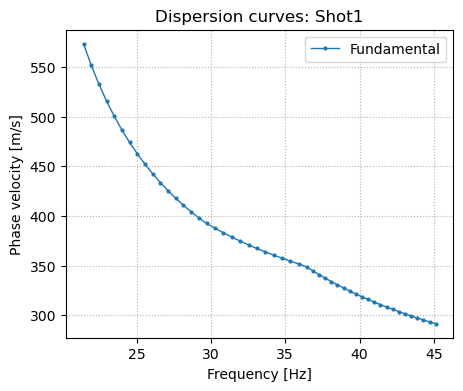

[--------------------------------------------------------------------------------
 Rayleigh-wave phase velocity
 
 Number of data points: 50
 Period bounds: [0.0222, 0.0467] s
 Mode: 0
 --------------------------------------------------------------------------------]

In [2]:
filename = "Shot1"
datadir = f"../data/disp_curves/{filename}/"

curves, data, t, v = swa.load_dc(datadir, filename, modes=[0])
curves

## 2. Modelling

Build the layered Earth initial model from top to bottom, with search boundaries
- `thickness[m]`  ---> [thick min, thick max]
- ` S-wave velocity[m/s]` ---> [vel min, vel max]
  
Create a `density_from_vp` function to perturbate the layer density within the optimization


In [3]:
# Initialize neutral model
model = EarthModel()

# Build model 
model.add(Layer([1, 3], [100, 300])) #layer
model.add(Layer([1, 3], [200, 400])) #layer 
model.add(Layer([1, 3], [350, 500])) #layer
model.add(Layer([1, 3], [350, 500])) #layer
model.add(Layer([1, 3], [350, 500])) #layer
model.add(Layer([2, 4], [500, 800])) #layer 

#density = lambda vp: 1.3 # Constant density (=1.3 g/cm3)
density_from_vp =  lambda vp: 0.31 * (vp)**0.25 # from Gardner et al. (1974) Formation velocity and density – the diagnostic basics for stratigraphic traps. Geophysics, 39(6), 770–780. https://doi.org/10.1190/1.1440465

# check
model

--------------------------------------------------------------------------------
Earth model parameters

------------------------------------------------------------
              d [km]           vs [km/s]              nu [-]
       min       max       min       max       min       max
------------------------------------------------------------
    1.0000    3.0000  100.0000  300.0000    0.2000    0.4000
    1.0000    3.0000  200.0000  400.0000    0.2000    0.4000
    1.0000    3.0000  350.0000  500.0000    0.2000    0.4000
    1.0000    3.0000  350.0000  500.0000    0.2000    0.4000
    1.0000    3.0000  350.0000  500.0000    0.2000    0.4000
    2.0000    4.0000  500.0000  800.0000    0.2000    0.4000
------------------------------------------------------------

Number of layers: 6
Number of parameters: 18
--------------------------------------------------------------------------------

## 3. Inversion

### 3.1 Stochastic Inversion parametrization
 uses `evodcinv` (Luu, 2023 - <https://doi.org/10.5281/zenodo.10112876>) 

In [4]:
# Parametrization and configuration

model.configure(
    optimizer="cpso",  # Evolutionary algorithm cpso
    misfit="rmse",  # Misfit function type
    density=density_from_vp,
    optimizer_args={
        "popsize": 20,  # Population size
        "maxiter": 100,  # Number of iterations
        "workers": -1,  # Number of cores
        "seed": 0},
    increasing_velocity=True, # optional
)

model

--------------------------------------------------------------------------------
Earth model parameters

------------------------------------------------------------
              d [km]           vs [km/s]              nu [-]
       min       max       min       max       min       max
------------------------------------------------------------
    1.0000    3.0000  100.0000  300.0000    0.2000    0.4000
    1.0000    3.0000  200.0000  400.0000    0.2000    0.4000
    1.0000    3.0000  350.0000  500.0000    0.2000    0.4000
    1.0000    3.0000  350.0000  500.0000    0.2000    0.4000
    1.0000    3.0000  350.0000  500.0000    0.2000    0.4000
    2.0000    4.0000  500.0000  800.0000    0.2000    0.4000
------------------------------------------------------------

Number of layers: 6
Number of parameters: 18
--------------------------------------------------------------------------------

### 3.2 Run Inversion and save the results
See stochopy's documentation for optimizer options <https://keurfonluu.github.io/stochopy/>

In [5]:
# Run inversion
#res = model.invert(curves)
res = model.invert(curves, maxrun=2)

Run 1  |████████████████████| 100% [0:02:40 / 0:00:00] - Misfit: 3.9328 
Run 2  |████████████████████| 100% [0:03:01 / 0:00:00] - Misfit: 4.4075 


In [6]:
# filter the results
#res = res.threshold(10)
#res = min(res, key=lambda x: x.misfit)  # Get the results for the run with the lowest misfit
res = res.threshold(5 * np.min(res.misfits))
res

--------------------------------------------------------------------------------
Best model out of 3625 models (2 runs)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    1.9716  411.6021  242.7742    1.3963              1.9716  242.7742    0.2333
    1.9298  830.5844  386.3931    1.6642              1.9298  386.3931    0.3619
    1.3864 1069.0844  436.9765    1.7726              1.3864  436.9765    0.3997
    2.6354 1191.2789  486.3376    1.8212              2.6354  486.3376    0.4000
    1.0010  876.2766  500.0000    1.6866              1.0010  500.0000    0.2586
    1.0000 1959.5063  799.9651    2.0625                   -  799.9651    0.4000
--

In [7]:
# save best model
figdir = '../figures/'
swa.save_model(res, filename)

📁 Model saved in: ../data/inv/Shot1


## 4. Plot results

/tmp/ipykernel_16902/921191612.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


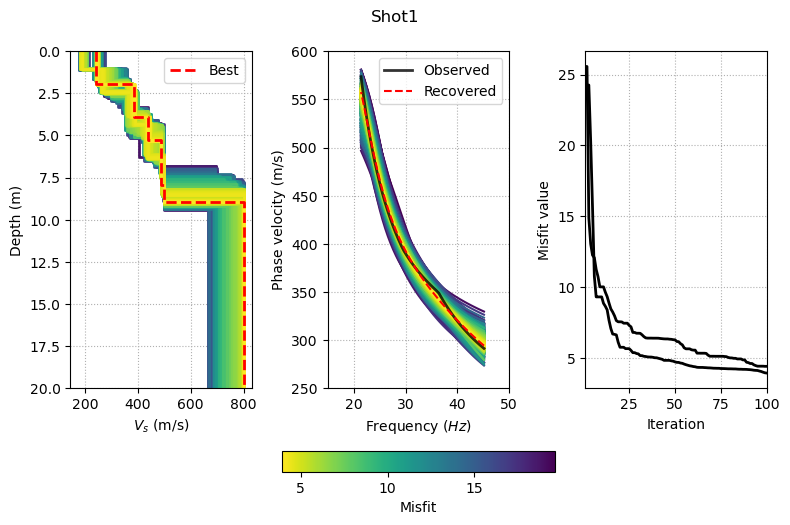

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(8, 4.5))

zmax, cmap = 20, "viridis_r"

# 1. Velocity model
res.plot_model("vs",zmax=zmax,show="all",ax=ax[0],plot_args={"cmap": cmap},)
res.plot_model("vs",zmax=zmax,show="best",ax=ax[0],
    plot_args={"color": "red","linestyle": "--","label": "Best"})

# 2. Dispersion curve
res.plot_curve(t, 0, "rayleigh", "phase", show="all", ax=ax[1], plot_args={"xaxis": "frequency", "cmap": cmap})
ax[1].plot(1/t, v, color="k", linewidth=2, label="Observed", alpha=.8)
res.plot_curve(t, 0, "rayleigh", "phase", show="best", ax=ax[1],
               plot_args={"xaxis": "frequency", "color": "r", "linestyle": "--", "label": "Recovered"})

# 3. Misfit
res.plot_misfit(ax=ax[2])

# Csmetics
for a in ax:
    a.grid(True, linestyle=":")
ax[0].legend(loc=1)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel(r'$V_s$ (m/s)') 
ax[1].set_ylim(250.0, 600.0)
ax[1].set_xlim(15.0, 50.0)
ax[1].xaxis.set_major_formatter(ScalarFormatter())
ax[1].xaxis.set_minor_formatter(ScalarFormatter())
ax[1].legend(loc=1)
ax[1].set_ylabel('Phase velocity (m/s)')
ax[1].set_xlabel('Frequency $(Hz)$')
    
norm = Normalize(vmin=res.misfits.min(), vmax=res.misfits.max())
smap = ScalarMappable(norm=norm, cmap=cmap)
axins = inset_axes(
    ax[1],
    width="150%",
    height="6%",
    loc="lower center",
    borderpad=-6.0)
cb = plt.colorbar(smap, cax=axins, orientation="horizontal")
cb.set_label("Misfit")
fig.suptitle(filename)
plt.tight_layout()

plt.savefig(figdir+filename+'_model.png', dpi=200)
plt.show()